# VAE

In [1]:
import sys
import os
import seaborn as sns
sys.path.append( '..' )

from VAE.smac_runhistories import *
from VAE.vae import *

## Parameter definition

In [2]:
data_dir  = os.path.normpath(os.path.join(os.getcwd(), "/mnt/d/runs/FIA/Com8_grown_together/oms"))
run_dir = os.path.normpath(os.path.join(os.getcwd(), "/mnt/d/runs/VAE/hyperparameter_optimization"))
results_dir = os.path.normpath(os.path.join(os.getcwd(), "/mnt/d/runs/VAE/results"))
verbosity = 1
backend_name = "tensorflow"
computation = "gpu"
outdir = Path(os.path.normpath(os.path.join(run_dir, f"smac_vae_{backend_name}_{computation}")))

time_step(message="Setup loaded", verbosity=verbosity)

X = read_data(data_dir, verbosity=verbosity)

Setup loaded (0.01993250846862793s)
Data loaded (6.5393593311309814s)


## Training

In [3]:
# On cluster


In [4]:
backend_name = "tensorflow"
computation = "cpu"
name = "fin" # "tied_fin"
project = f"vae_{backend_name}_{computation}_{name}"
outdir = Path(os.path.normpath( os.path.join("/mnt/d/runs/VAE/training", project)))

In [5]:
model = keras.saving.load_model(os.path.join(outdir, f"{project}_70.keras"), custom_objects=None, compile=True, safe_mode=True)

In [6]:
l = model.get_layer(index=2)
[w.numpy() for w in l.weights]

[array([[ 1.8608081e-03, -1.2119460e-04, -6.4880756e-04, ...,
          2.1711826e-04,  2.1051411e-03, -1.9367132e-03],
        [-2.4827057e-03,  2.3156053e-03,  8.5935619e-04, ...,
          9.0350356e-04, -1.4717838e-03,  1.2973022e-03],
        [ 2.2732248e-03,  1.9280213e-03, -1.5604113e-03, ...,
          1.1174656e-03, -2.5925387e-03, -1.5964179e-03],
        ...,
        [-1.8787261e-03,  7.8781601e-04,  2.4736198e-03, ...,
          1.4302721e-03,  2.1102005e-03, -7.1878382e-04],
        [-1.7664256e-04, -2.2336473e-03,  2.1912814e-03, ...,
          1.2855148e-03,  2.5092657e-03,  1.1763293e-03],
        [ 2.8664012e-05,  1.6966597e-03,  1.0975816e-03, ...,
         -2.3936979e-03,  1.5942417e-03,  1.6515502e-03]], dtype=float32),
 array([ 4.33433615e-06,  6.96741927e-06, -4.18437048e-06, -8.42837210e-07,
         1.19190317e-05,  2.18868354e-05,  1.46755474e-05, -1.10524743e-05,
        -1.32546018e-04,  6.11954238e-05, -4.98186364e-06, -5.88605690e-06,
         2.22786020e-0

In [17]:
model.load_weights(os.path.join(outdir, f"{project}.weights.h5"))

In [ ]:
l = model.get_layer(index=2)
[w.numpy() for w in l.weights]

[array([[ 1.8604200e-03, -1.2093023e-04, -6.4765092e-04, ...,
          2.1747120e-04,  2.1046984e-03, -1.9371085e-03],
        [-2.4817102e-03,  2.3144013e-03,  8.5670140e-04, ...,
          9.0267329e-04, -1.4703367e-03,  1.2985582e-03],
        [ 2.2735924e-03,  1.9278702e-03, -1.5615110e-03, ...,
          1.1172092e-03, -2.5919667e-03, -1.5960432e-03],
        ...,
        [-1.8787261e-03,  7.8781601e-04,  2.4736198e-03, ...,
          1.4302721e-03,  2.1102005e-03, -7.1878382e-04],
        [-1.7664256e-04, -2.2336473e-03,  2.1912814e-03, ...,
          1.2855148e-03,  2.5092657e-03,  1.1763293e-03],
        [ 2.8664012e-05,  1.6966597e-03,  1.0975816e-03, ...,
         -2.3936979e-03,  1.5942417e-03,  1.6515502e-03]], dtype=float32),
 array([-3.53410564e-06,  1.39855661e-06,  9.00486611e-06,  8.88300656e-06,
         1.40513630e-05,  3.17155718e-05,  3.19823630e-05, -1.83887842e-05,
        -1.41322162e-04,  6.60554797e-05, -1.45684282e-07, -1.14129234e-05,
         5.51591893e-0

In [7]:
model.summary()

Model: "fia_vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_intermediate            │ ?                      │   619,125,435 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_mu (Dense)               │ ?                      │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_sigma (Dense)            │ ?                      │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_reparametrization        │ ?                      │             0 │
│ (Sampling)                      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder (Sequential)            │ ?                      │   619,950,415 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,717,230,073 (13.85 GB)

 Trainable params: 1,239,076,690 (4.62 GB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,478,153,383 (9.23 GB)

## Reconstruction

In [8]:
reconstructed_data = pd.DataFrame(model(X).numpy())

### Show model

In [11]:
model_plot = keras.utils.plot_model( model, show_shapes=True, show_dtype=False, show_layer_names=True,
                                     rankdir="TB", expand_nested=True, dpi=300, subgraph=True,
                                     show_layer_activations=True, show_trainable=True )
model_plot

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


## Plot training

In [12]:
history = pd.read_csv(os.path.join(outdir, f"{project}.history.tsv"), sep="\t", index_col="Unnamed: 0")
history

,kl_loss,loss,reconstruction_loss,val_kl_loss,val_loss,val_reconstruction_loss
0,5.320708e-05,0.000190,0.000128,0.000004,0.000035,0.000031
1,2.314647e-06,0.000024,0.000021,0.000000,0.000007,0.000007
2,1.589457e-07,0.000005,0.000005,0.000000,0.000002,0.000002
3,0.000000e+00,0.000002,0.000002,0.000000,0.000001,0.000001
4,0.000000e+00,0.000001,0.000001,0.000000,0.000001,0.000001
...,...,...,...,...,...,...
95,0.000000e+00,0.000001,0.000001,0.000000,0.000001,0.000001
96,0.000000e+00,0.000001,0.000001,0.000000,0.000001,0.000001
97,0.000000e+00,0.000001,0.000001,0.000000,0.000001,0.000001
98,0.000000e+00,0.000001,0.000001,0.000000,0.000001,0.000001


In [13]:
training_losses = history[[col for col in history.columns if not col.startswith("val")]]
validation_losses = history[[col for col in history.columns if col.startswith("val")]]

## Plot results

In [14]:
# reconstructed_data = pd.read_csv("/mnt/d/runs/VAE/training/vae_tensorflow_cpu_hm_1/vae_tensorflow_cpu_hm_1.prediction.tsv", index_col="Unnamed: 0")#, sep="\t")

In [15]:
plot_df = pd.DataFrame(reconstructed_data.loc[0].values, index=X.columns, columns=["inty"]).reset_index()
plot_df_2 = pd.DataFrame(X.iloc[0].values, index=X.columns, columns=["inty"]).reset_index()

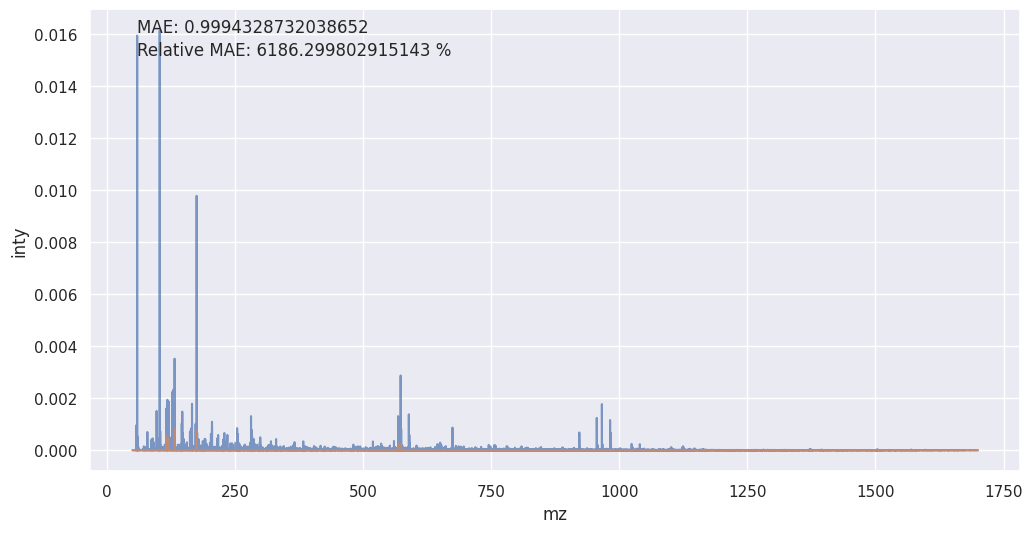

In [16]:
mae = np.mean(np.sum( np.abs((plot_df_2["inty"] - plot_df["inty"])) ))
rel_mae = mae / np.max(plot_df_2["inty"])

sns.set_theme(rc={"figure.figsize":(12, 6)})
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty", alpha=0.7)
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7)
plt.annotate(f"MAE: {mae}", xy=(0.05, 0.95), xycoords='axes fraction')
plt.annotate(f"Relative MAE: {rel_mae *100} %", xy=(0.05, 0.90), xycoords='axes fraction')
plt.show()

(965.9, 966.1)

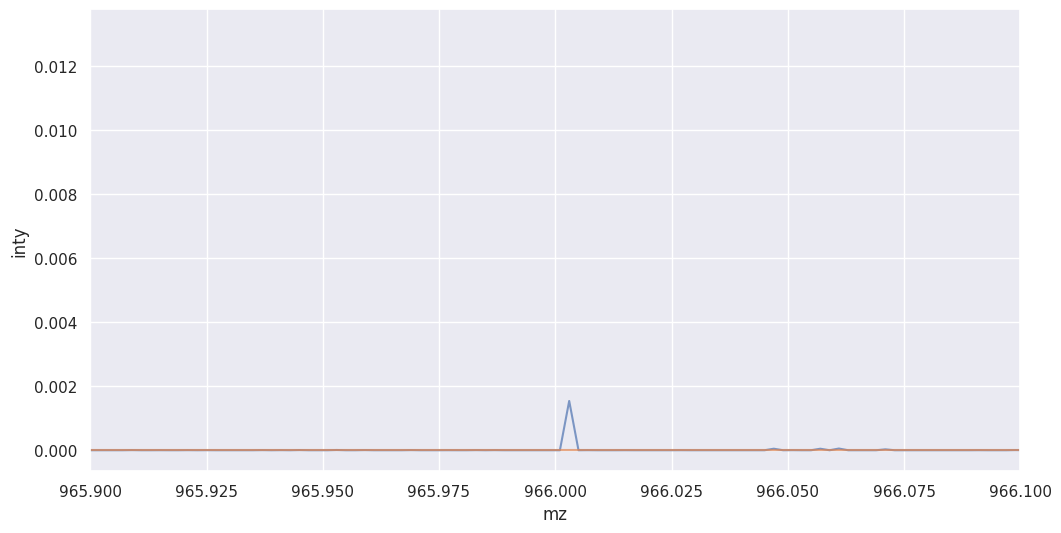

In [ ]:
sns.set_theme(rc={"figure.figsize":(12, 6)})
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty" ,alpha=0.7)
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7)
ax.set_xlim(965.9, 966.1)

(-0.0001, 0.003)

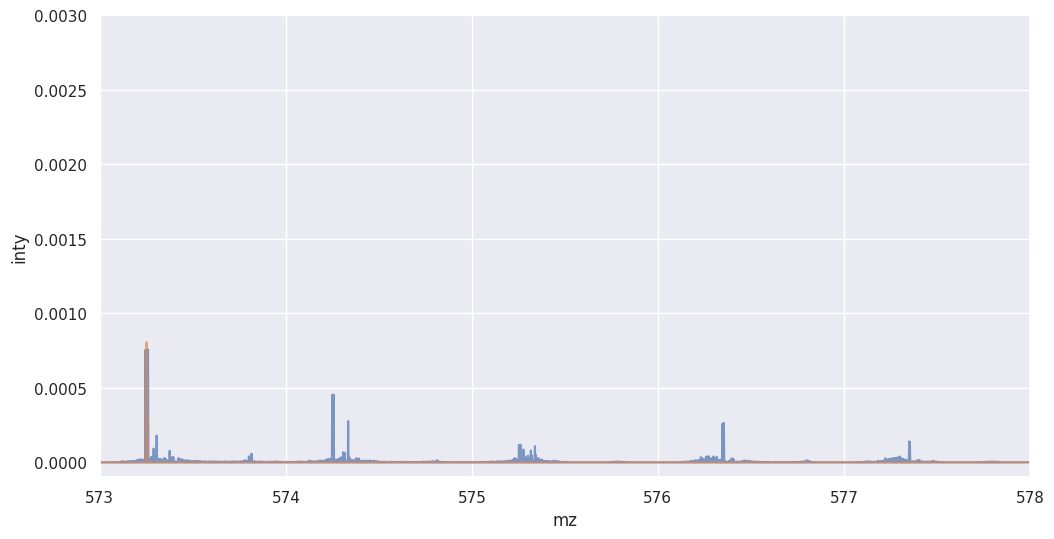

In [ ]:
sns.set_theme(rc={"figure.figsize":(12, 6)})
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty" ,alpha=0.7)
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7)
ax.set_xlim(573, 578)
ax.set_ylim(-0.0001, 0.003)

(-0.0001, 0.0022)

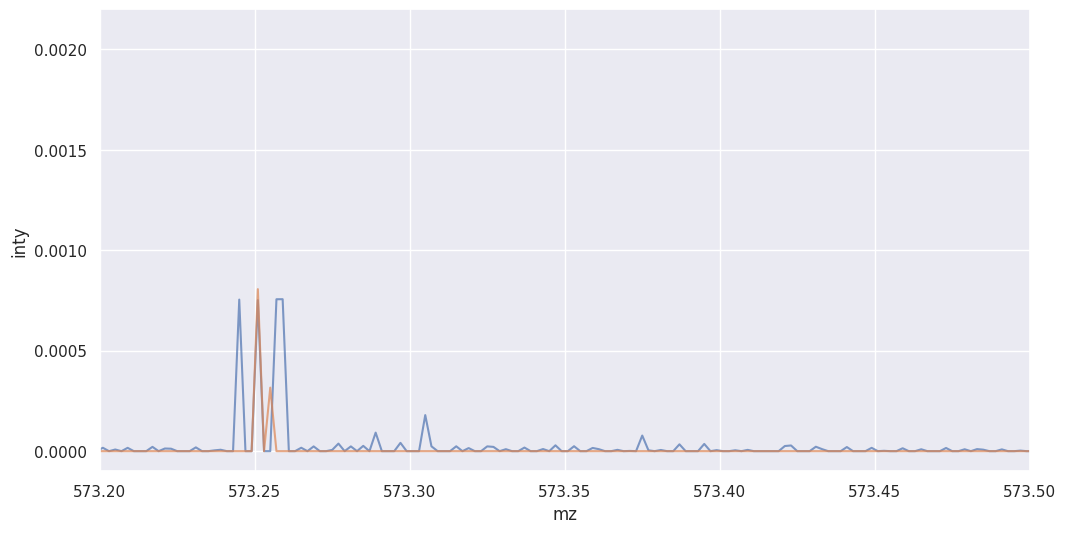

In [ ]:
sns.set_theme(rc={"figure.figsize":(12, 6)})
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty" ,alpha=0.7)
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7)
ax.set_xlim(573.2, 573.5)
ax.set_ylim(-0.0001, 0.0022)

## Classification

In [ ]:
vae_enc = pd.DataFrame( model.encode_mu(X) )
vae_enc

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000012,-0.000016,-0.000013,-0.000026,0.000008,-0.000020,0.000007,9.349833e-07,0.000014,0.000013,-0.000053,-0.000035,-0.000002,-0.000010,-3.682797e-06,0.000014,0.000007,0.000030,0.000043,-1.975632e-06
1,0.000011,-0.000014,-0.000014,-0.000027,0.000009,-0.000020,0.000008,2.326378e-07,0.000013,0.000014,-0.000053,-0.000036,-0.000002,-0.000010,-4.357596e-06,0.000012,0.000009,0.000029,0.000041,-1.605015e-06
2,0.000013,-0.000017,-0.000014,-0.000026,0.000009,-0.000020,0.000007,-1.576780e-06,0.000012,0.000014,-0.000053,-0.000034,-0.000003,-0.000011,-5.216563e-06,0.000011,0.000009,0.000030,0.000041,-4.687145e-07
3,0.000013,-0.000015,-0.000013,-0.000027,0.000008,-0.000021,0.000008,6.659529e-07,0.000014,0.000013,-0.000053,-0.000034,-0.000002,-0.000010,-3.965164e-06,0.000013,0.000009,0.000029,0.000042,-2.627074e-06
4,0.000012,-0.000014,-0.000013,-0.000026,0.000009,-0.000020,0.000007,3.820060e-08,0.000014,0.000013,-0.000053,-0.000035,-0.000003,-0.000010,-3.462603e-06,0.000013,0.000009,0.000030,0.000043,-2.317770e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,0.000012,-0.000015,-0.000012,-0.000026,0.000010,-0.000021,0.000008,6.570899e-07,0.000014,0.000013,-0.000054,-0.000036,-0.000003,-0.000009,-3.925461e-06,0.000013,0.000009,0.000030,0.000043,-2.338627e-06
64,0.000012,-0.000015,-0.000013,-0.000026,0.000009,-0.000020,0.000007,4.930080e-07,0.000013,0.000013,-0.000053,-0.000034,-0.000003,-0.000011,-4.398651e-06,0.000012,0.000009,0.000029,0.000042,-2.028784e-06
65,0.000012,-0.000015,-0.000013,-0.000026,0.000010,-0.000020,0.000008,2.795805e-07,0.000014,0.000013,-0.000053,-0.000035,-0.000004,-0.000009,-3.180223e-06,0.000013,0.000008,0.000030,0.000043,-1.906870e-06
66,0.000012,-0.000015,-0.000015,-0.000026,0.000008,-0.000018,0.000007,-8.836842e-07,0.000014,0.000014,-0.000051,-0.000032,-0.000001,-0.000012,-3.799989e-06,0.000015,0.000007,0.000030,0.000041,-6.686696e-07


In [ ]:
vae_enc.to_csv( os.path.join("/mnt/d/runs/VAE/results", "encoded_mu.tsv"), sep="\t" )